In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('land_train.csv') # loading the dataset

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,I1,I2,I3,I4,I5,I6,clusterID,target
0,207,373,267,1653,886,408,0.721875,-1.023962,2.750628,0.530316,0.208889,0.302087,6,1
1,194,369,241,1539,827,364,0.729213,-1.030143,2.668501,0.546537,0.203306,0.300930,6,1
2,214,385,264,1812,850,381,0.745665,-1.107047,3.000315,0.546156,0.181395,0.361382,6,1
3,212,388,293,1882,912,402,0.730575,-1.077747,3.006150,0.530083,0.156835,0.347172,6,1
4,249,411,332,1773,1048,504,0.684561,-0.941562,2.713079,0.494370,0.205742,0.257001,6,1


In [4]:
dfs = df.sample(frac=0.1).reset_index(drop=True) # shuffles the data and takes a fraction of it
dfs.shape

(48800, 14)

# Column level preprocessing
### Scatter Plot

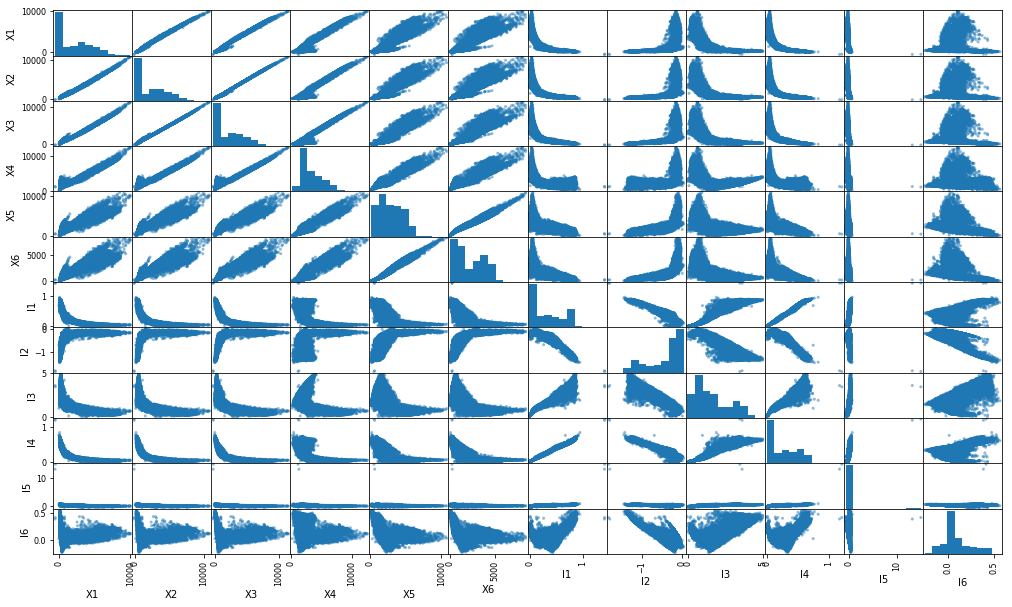

In [93]:
# scatter plot of a part of data
pd.plotting.scatter_matrix(dfs[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6']], figsize=(17,10));

### Correlation Plot

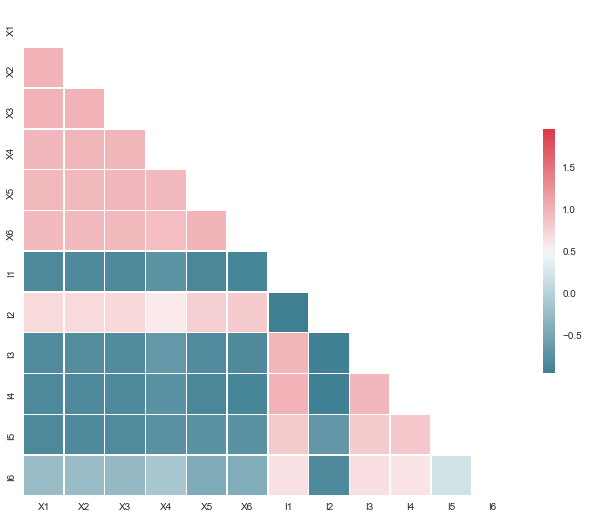

In [103]:
import seaborn as sns
sns.set(style="white")

# finding correlation
corr = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.5, square=True, linewidths=.5, cbar_kws={"shrink": .5});

From the scatter plot and correlation plot, we can conclude that-
- The $X$ features are almost linearly correlated with each other. Moreover, they show similar correlation with $I$ features. Therefore, we can merge them into one (average).
- $I5$ is almost constant and shows less variance (see the histogram). Therefore, it can be dropped.
- $I1$ and $I4$ are highly correlated. They can be merged (average).
- $I2$ shows inverse correlation with $I1$. It can be dropped.

Remaining columns: $X$<sub>avg</sub>, $I$<sub>14</sub>, $I$<sub>3</sub>, $I$<sub>6</sub>. 

#### Note: Highly correlated columns are dropped since they provide no extra information to the model and hampers the performance.

### Selecting features

In [114]:
# preprocessing columns
df['X'] = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].mean(axis=1) # merging all X features in one
df = df.drop(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], axis=1)      # dropping the rest
df['I14'] = df[['I1', 'I4']].mean(axis=1)                       # averaging I1 and I4
df = df.drop(['I1', 'I4', 'I2', 'I5'], axis=1)                  # dropping the rest

In [115]:
df.head()

,I3,I6,clusterID,target,X,I14
0,2.750628,0.302087,6,1,632.333333,0.626095
1,2.668501,0.300930,6,1,589.000000,0.637875
2,3.000315,0.361382,6,1,651.000000,0.645910
3,3.006150,0.347172,6,1,681.500000,0.630329
4,2.713079,0.257001,6,1,719.500000,0.589465


In [117]:
# df.to_csv('land_train_pruned.csv', index=False) # saving the data

# Row level preprocessing

In [185]:
df.describe()

,I3,I6,clusterID,target,X,I14
count,487998.000000,487998.000000,487998.000000,487998.000000,487998.000000,487998.000000
mean,1.602914,0.098514,4.180263,1.062301,2567.438750,0.295633
std,1.106819,0.147183,1.645535,0.350805,1840.983848,0.250844
min,-0.177197,-0.297521,1.000000,1.000000,-83.666667,-0.848529
25%,0.694444,0.016150,3.000000,1.000000,1015.000000,0.067379
50%,1.267495,0.056333,3.000000,1.000000,1839.000000,0.188264
75%,2.430122,0.161845,6.000000,1.000000,4015.666667,0.515738
max,5.663032,0.662566,8.000000,4.000000,10682.333333,5.755439


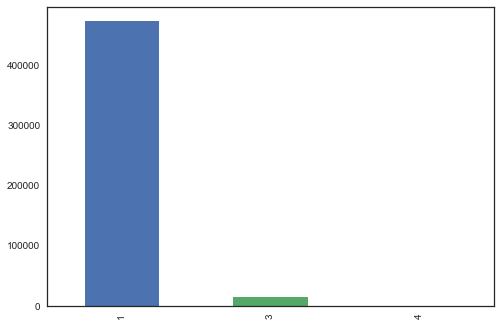

In [186]:
df.target.value_counts().plot('bar');

Samples per example: <br>
1: 472987 (97%) <br>
2: 0 <br>
3: 14630 <br>
4: 381 <hr>
This clearly shows the imbalance in classes. While training on such data even if the model predits <b>class 1</b> everytime, the accuracy will be 97%.
Therefore, we need to balance the classes and for this, the approach used is given below.

- Due to very less samples in Class 4, it can be removed.
- Class 1 can be divided randomly into 10 subparts (Samples in each part - 47300).
- Class 3 can be duplicated 2 times (Samples - 43890).
- Trian 10 separate classification models with one part of Class 1 each along with same Class 3 samples in each model.
- Take the average of all models while testing.

### Normalizing features

In [190]:
from sklearn import preprocessing

x = df[['I3', 'I6', 'I14', 'X']].values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_n = pd.DataFrame(x_scaled, columns=['I3', 'I6', 'I14', 'X'])

In [191]:
df_norm = df[['clusterID', 'target']].join(df_n)

In [192]:
df_norm.head()

,clusterID,target,I3,I6,I14,X
0,6,1,0.501320,0.624535,0.223294,0.066506
1,6,1,0.487258,0.623330,0.225077,0.062481
2,6,1,0.544073,0.686296,0.226294,0.068240
3,6,1,0.545072,0.671495,0.223935,0.071073
4,6,1,0.494891,0.577575,0.217747,0.074602


### Splitting data into 10 parts 

In [193]:
# separating classes
df_1 = df_norm[df_norm.target==1]
df_1 = df_1.sample(frac=1).reset_index(drop=True) # shuffling rows
df_3 = df_norm[df_norm.target==3]

In [194]:
df_1.shape[0], df_3.shape[0]

(472987, 14630)

In [195]:
df_1_split = np.split(df_1, np.arange(47300, 472987, 47300),axis=0) # splits dataframe (of Target=1) in 10 

In [196]:
[i.shape for i in df_1_split]

[(47300, 6),
 (47300, 6),
 (47300, 6),
 (47300, 6),
 (47300, 6),
 (47300, 6),
 (47300, 6),
 (47300, 6),
 (47300, 6),
 (47287, 6)]

In [197]:
df_3_dup = pd.concat([df_3]*3, ignore_index=True) # duplicate data (of Target=3) 3 times
df_3_dup.shape

(43890, 6)

In [198]:
for i in range(len(df_1_split)):
    df_1_split[i] = df_1_split[i].append(df_3_dup, ignore_index=True) # merge Target 1 and 3

In [199]:
[i.shape for i in df_1_split]

[(91190, 6),
 (91190, 6),
 (91190, 6),
 (91190, 6),
 (91190, 6),
 (91190, 6),
 (91190, 6),
 (91190, 6),
 (91190, 6),
 (91177, 6)]

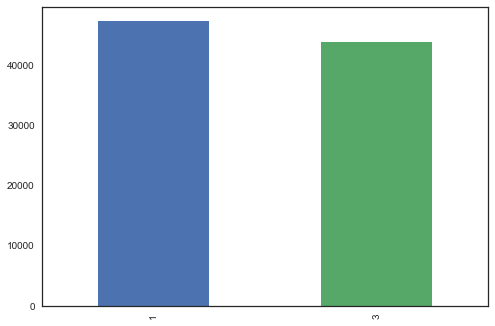

In [200]:
df_1_split[9].target.value_counts().plot('bar');

In [201]:
# saving all parts
# for i in range(len(df_1_split)):
#     df_1_split[i].to_csv(f'land_train_split_{i+1}.csv', index=False)

# Preprocessing Test Data

In [210]:
df_test = pd.read_csv('land_test.csv')
df_test.shape

(2000000, 13)

In [209]:
df_test.head()

,X1,X2,X3,X4,X5,X6,I1,I2,I3,I4,I5,I6,clusterID
0,338,554,698,1605,1752,1310,0.393834,-0.350045,1.565423,0.311659,0.304781,-0.043789,6
1,667,976,1187,1834,1958,1653,0.214167,-0.181467,1.050679,0.196439,0.164085,-0.032700,4
2,249,420,402,1635,1318,736,0.605302,-0.712650,2.268984,0.441984,0.293497,0.107348,6
3,111,348,279,1842,743,328,0.736917,-1.162062,3.074176,0.551699,0.080725,0.425145,6
4,349,559,642,1534,1544,989,0.409926,-0.406678,1.607795,0.323984,0.212753,-0.003249,6


In [211]:
# preprocessing columns
df_test['X'] = df_test[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].mean(axis=1) # merging all X features in one
df_test = df_test.drop(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], axis=1)      # dropping the rest
df_test['I14'] = df_test[['I1', 'I4']].mean(axis=1)                       # averaging I1 and I4
df_test = df_test.drop(['I1', 'I4', 'I2', 'I5'], axis=1)                  # dropping the rest

In [213]:
x_test = df_test[['I3', 'I6', 'I14', 'X']].values # returns a numpy array
x_test_scaled = min_max_scaler.transform(x_test)  # applying scaler
df_test_n = pd.DataFrame(x_test_scaled, columns=['I3', 'I6', 'I14', 'X'])
df_test_norm = df_test[['clusterID']].join(df_test_n)

In [219]:
df_test_norm.shape

(2000000, 5)

In [220]:
df_test_norm.head()

,clusterID,I3,I6,I14,X
0,6,0.298382,0.264280,0.181902,0.104635
1,4,0.210245,0.275830,0.159576,0.135875
2,6,0.418850,0.421701,0.207780,0.081460
3,6,0.556720,0.752709,0.226051,0.064292
4,6,0.305637,0.306505,0.184054,0.094727


In [215]:
# df_test_norm.to_csv('land_test_preprocessed.csv')

# Model

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [3]:
# different classifiers
num_models = [KNeighborsClassifier(n_neighbors=5), svm.SVC(), LogisticRegression(), GaussianNB(),
              AdaBoostClassifier(), BernoulliNB(), MLPClassifier(),
              RandomForestClassifier(), DecisionTreeClassifier('entropy')]

In [4]:
# training 9 different model on different data splits
# taking average of 9 predictions while testing
# testing set is the 10th data split

models = []
for i in range(9):
    df_train = pd.read_csv('land_train_split_{}.csv'.format(i+1))
    df_train = df_train.sample(frac=1).reset_index(drop=True)

    x = df_train.drop('target', axis=1).values
    y = df_train.target.values
    
    model = num_models[7]
    models.append(model.fit(x, y))
    
    print(f'Model {i+1} trained.', end='\r')

In [5]:
# loading the test set
df_test = pd.read_csv('land_train_split_10.csv')
df_test = df_test.sample(frac=1).reset_index(drop=True)

x_test = df_test.drop('target', axis=1).values
y_test = df_test.target.values

In [30]:
# making predictions
predictions = []
for i in range(9):
    predictions.append(list(models[i].predict(x_test)))
predictions = np.array(predictions)

In [31]:
# getting the mojority Class

pred_maj = []
for i in range(predictions.shape[1]):
    (values, counts) = np.unique(predictions[:,i], return_counts=True)
    pred_maj.append(values[np.argmax(counts)])
pred_maj = np.array(pred_maj)

Accuracy: 97.58%
Precision: 0.98
Recall: 0.97
F1 score: 0.98


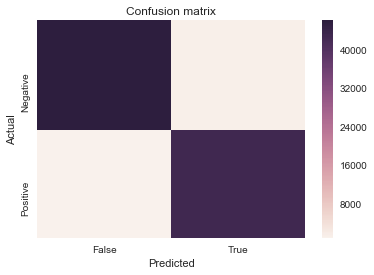

In [32]:
print('Accuracy: {:.2f}%'.format(np.mean(pred_maj==y_test)*100))

precision, recall, f1 = precision_score(y_test, pred_maj), recall_score(y_test, pred_maj), f1_score(y_test, pred_maj)
print('Precision: {:.2f}\nRecall: {:.2f}\nF1 score: {:.2f}'.format(precision, recall, f1))

cm = confusion_matrix(y_test, pred_maj, labels=[1,3])
sns.heatmap(cm, xticklabels=['False', 'True'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix');

# Results

| Classifier | Accuracy | F1 Score |
| ---------- | -------- | -- |
| Decision Tree (Entropy) | 99.11% | 0.99 |
| Decision Tree (Gini) | 99.15% | 0.99 |
| Random Forest | 99.23% | 0.99 |
| KNN | 98.53% | 0.99 |
| Logistic Regression | 91.38% | 0.92 |
| Gaussian Naive Bayes | 89.83% | 0.90 |
| Bernoulli Naive Bayes | 51.86% | 0.68 |
| Adaboost Classifier | 95.87% | 0.90 |
| ANN | 89.83% | 0.90 |
| All | 97.58% | 0.98 |


# Getting predictions for test set

In [21]:
df_test_set = pd.read_csv("land_test_preprocessed.csv")
df_test_set.drop('Unnamed: 0', inplace=True, axis=1)
df_test_set.head()

,clusterID,I3,I6,I14,X
0,6,0.298382,0.264280,0.181902,0.104635
1,4,0.210245,0.275830,0.159576,0.135875
2,6,0.418850,0.421701,0.207780,0.081460
3,6,0.556720,0.752709,0.226051,0.064292
4,6,0.305637,0.306505,0.184054,0.094727


In [39]:
# predictions
predictions = []
for i in range(9):
    predictions.append(list(models[i].predict(df_test_set.values)))
predictions = np.array(predictions)

In [40]:
# getting the mojority Class
pred_maj = []
for i in range(predictions.shape[1]):
    (values, counts) = np.unique(predictions[:,i], return_counts=True)
    pred_maj.append(values[np.argmax(counts)])
pred_maj = np.array(pred_maj)

In [41]:
pred_maj.shape

(2000000,)

In [45]:
df_sub = pd.DataFrame(pred_maj, columns=['target'])
df_sub.head()

,target
0,3
1,3
2,1
3,1
4,3


In [46]:
df_sub.to_csv('submission.csv', index=False)

# Analysis

In [5]:
dfa = pd.read_csv('land_train_split_1.csv')

In [6]:
dfa.groupby(dfa.target).describe().T

target                      1             3
I14       count  47300.000000  43890.000000
          mean       0.172823      0.178143
          std        0.038544      0.010856
          min        0.126043      0.128314
          25%        0.138245      0.172255
          50%        0.153272      0.177356
          75%        0.208025      0.183939
          max        0.313051      0.236896
I3        count  47300.000000  43890.000000
          mean       0.303832      0.300403
          std        0.192337      0.065502
          min        0.005789      0.024574
          25%        0.145690      0.265956
          50%        0.234960      0.289333
          75%        0.455870      0.326778
          max        0.908952      0.874047
I6        count  47300.000000  43890.000000
          mean       0.418548      0.235797
          std        0.151682      0.076489
          min        0.077088      0.029555
          25%        0.330767      0.190215
          50%        0.371948      0.218487
          75%        0.483560      0.258432
          max        0.947382      0.818775
X         count  47300.000000  43890.000000
          mean       0.251571      0.131445
          std        0.172705      0.032215
          min        0.015047      0.061382
          25%        0.101817      0.112948
          50%        0.202729      0.126339
          75%        0.388372      0.142888
          max        0.992523      0.519661
clusterID count  47300.000000  43890.000000
          mean       4.127294      5.833698
          std        1.634507      0.906823
          min        1.000000      1.000000
          25%        3.000000      6.000000
          50%        3.000000      6.000000
          75%        6.000000      6.000000
          max        8.000000      8.000000

In [ ]:
estimator = models[0].estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ['clusterID', 'I3', 'I6', 'I14', 'X'],
                class_names = ['1', '3'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
import pydot
(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('somefile.png')

In [28]:
# taking sum of all GINI indexes
a = models[0].feature_importances_
for i in range(8):
    a += models[i+1].feature_importances_

In [31]:
a

array([2.10152634, 0.58177282, 3.40019577, 2.06218839, 0.85431669])

The model cannot be visualized because of its size, so I have taken the sum of <b>gini index</b> of attributes, which are shown below.<br>
clusterID: 2.10 <br>
I3: 0.58 <br>
I6: 3.40 <br>
I14: 2.06 <br>
X: 0.85 <br>
<hr>
Clearly, $I6$ classifies the data best.